# Analiza zawartości Netflixa
 
Wykorzystana baza: netflix_titles.csv  
Źródło: https://www.kaggle.com/datasets/shivamb/netflix-shows?datasetId=434238&searchQuery=R  
Ostatnia aktualizacja bazy: 27.09.2021r  
Data pobrania: 22.01.2023r  

In [2]:
library(tidyr)
library(dplyr)
library(ggrepel)
library(treemap)

In [90]:
df = data.frame(read.csv("netflix_titles.csv", header=TRUE, sep=",", dec=".", stringsAsFactors = FALSE))
glimpse(df)

Observations: 8,807
Variables: 12
$ show_id      <chr> "s1", "s2", "s3", "s4", "s5", "s6", "s7", "s8", "s9", ...
$ type         <chr> "Movie", "TV Show", "TV Show", "TV Show", "TV Show", "...
$ title        <chr> "Dick Johnson Is Dead", "Blood & Water", "Ganglands", ...
$ director     <chr> "Kirsten Johnson", "", "Julien Leclercq", "", "", "Mik...
$ cast         <chr> "", "Ama Qamata, Khosi Ngema, Gail Mabalane, Thabang M...
$ country      <chr> "United States", "South Africa", "", "", "India", "", ...
$ date_added   <chr> "September 25, 2021", "September 24, 2021", "September...
$ release_year <int> 2020, 2021, 2021, 2021, 2021, 2021, 2021, 1993, 2021, ...
$ rating       <chr> "PG-13", "TV-MA", "TV-MA", "TV-MA", "TV-MA", "TV-MA", ...
$ duration     <chr> "90 min", "2 Seasons", "1 Season", "1 Season", "2 Seas...
$ listed_in    <chr> "Documentaries", "International TV Shows, TV Dramas, T...
$ description  <chr> "As her father nears the end of his life, filmmaker Ki...


### Sprawdzenie w których kolumnach znajdują się puste komórki:

In [4]:
dfx = which(df == "", arr.ind = T)
dfx = table(dfx[, 2])
dfBlanks <- data.frame(NumerKolumny = colnames(df[as.numeric(names(dfx))]), IloscPowtorzen = as.numeric(dfx))

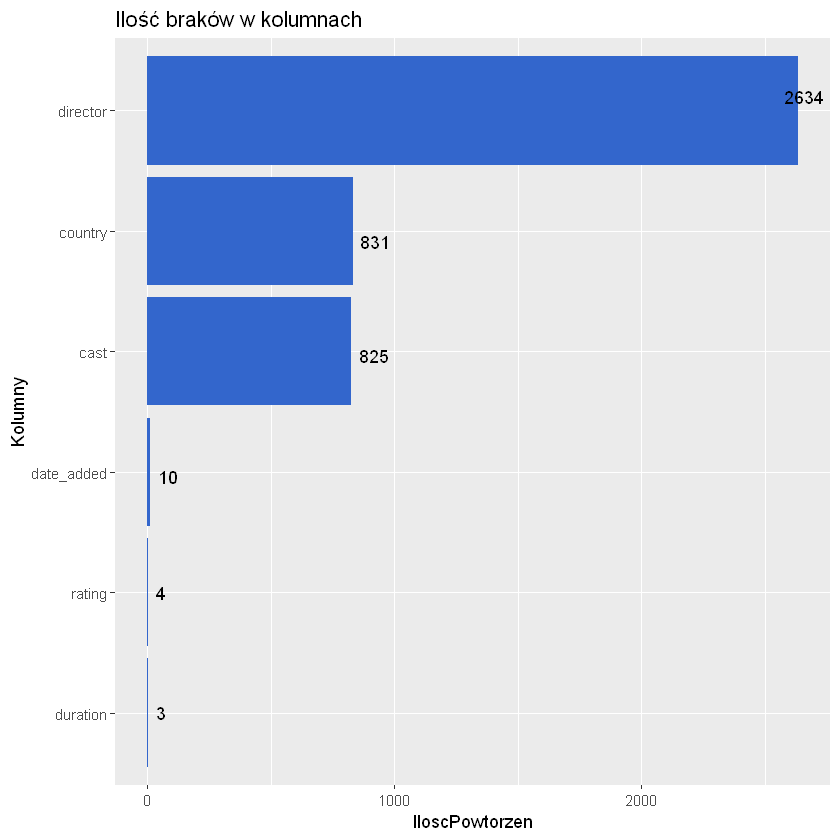

In [5]:
ggplot(dfBlanks, aes(x = reorder(NumerKolumny, IloscPowtorzen), y = IloscPowtorzen, fill = NumerKolumny)) + 
  geom_col() +  
  labs(x = "Kolumny", y = "IloscPowtorzen") + 
  ggtitle("Ilość braków w kolumnach") +
  theme(legend.position = "none") +
  scale_fill_manual(values = c(rep("#3366CC", 6))) +
  geom_text_repel(aes(label = stat(y), group = factor(NumerKolumny)), position = position_nudge_repel(y = 1)) + 
  coord_flip()

#### Można pozbywać się pustych danych na kilka sposobów
1. wszystkie wiersze zawierające - usunąć
2. zamienić je na coś spodziewanego np "Brak informacji"
3. przewidzieć wartość - np na najczęściej występujący


W przypadku:
- kraju, 
- obsady, 
- daty dodania, 
- reżysera,
- długości.   

Użyjemy punktu 2. Jeśli zaś chodzi o kategorię, skorzystamy z 3 opcji  

Po dokładniejszym zastanowieniu w naszej analizie nie wykorzystamy w żaden sposób kolumn: "cast" oraz "director"  
Więc zamiast uzupełniać dane w tych kolumnach, można się ich po prostu pozbyć

In [6]:
df = df[, -4]
df = df[, -4]
df$duration[df$duration == ""] = "Brak danych"
df$country[df$country == ""] = "Brak danych"
df$date_added[df$date_added == ""] = "Brak danych"
df$date_added = trimws(df$date_added)

Podczas przygotowania danych do uzupełnienia braków, zauważamy  
    że w kolumnie znajdują się niepoprawne dane   
"66 min", "74min" oraz "84 min"  
Kojarzymy format danych z następną kolumną - duration

In [7]:
names(sort(table(df$rating)))

[1] "66 min"   "74 min"   "84 min"   "NC-17"    "UR"       ""        
 [7] "TV-Y7-FV" "G"        "NR"       "TV-G"     "PG"       "TV-Y"    
[13] "TV-Y7"    "PG-13"    "R"        "TV-PG"    "TV-14"    "TV-MA"

Sprawdzamy czy wiersze z tymi danymi posiadają rekordy w duration

In [8]:
checking <- df[is.element(df$rating, c('66 min','74 min', '84 min')),]
checking[c("duration","type")]

,duration,type
5542,Brak danych,Movie
5795,Brak danych,Movie
5814,Brak danych,Movie


Jak widzimy były to puste pola, dodatkowo typ każdego z nich to film.  
Stąd wniosek, że ten błąd wynika z pomyłki ludzkiej, więc należy zamienić dane miejscami,  
a następnie przypiszemy do pustych jak i błędnych danych najczęściej występujący typ

In [9]:
df$duration[df$rating == "66 min"] <- "66 min"
df$duration[df$rating == "74 min"] <- "74 min"
df$duration[df$rating == "84 min"] <- "84 min"
df$rating[is.element(df$rating, c('66 min','74 min', '84 min'))] = names(sort(-table(df$rating)))[1]
df$rating[df$rating == ""] = names(sort(-table(df$rating)))[1]

In [10]:
dfx = which(df == "", arr.ind = T)
dfx = table(dfx[, 2])
dfx

< table of extent 0 >

Pozbyliśmy się wszystkich braków wartości

## Sprawdzanie liczby unikalnych wartości  
by wiedzieć co warto sklasyfikować


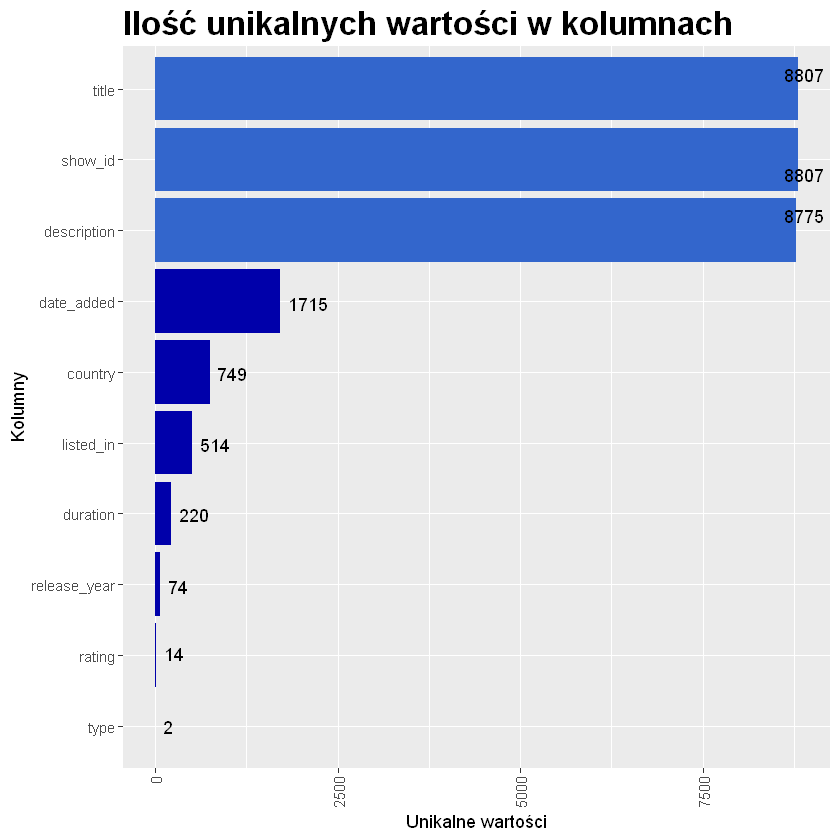

In [11]:
uniques <- apply(df, MARGIN = 2, FUN = function(x) length(unique(x)))
                 
# Dołożenie do liczb odpowiadające im nazwy kolumn
uniques <- data.frame(Kolumny = names(uniques), Unikalne = uniques, stringsAsFactors =  F)
                 
ggplot(uniques, aes(x = reorder(Kolumny, Unikalne), y = Unikalne, fill = Kolumny)) +
  geom_col() +
  ggtitle("Ilość unikalnych wartości w kolumnach") +
  theme(plot.title = element_text(size=20, face="bold"),) +
  theme(legend.position = "none") +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
  scale_fill_manual(values = c(rep("#0000AA",2), "#3366CC", rep("#0000AA",4), "#3366CC","#3366CC", "#0000AA")) + 
  labs(x = "Kolumny", y = "Unikalne wartości") + 
  geom_text_repel(aes(label = stat(y), group = factor(Unikalne)), position = position_nudge_repel(y = 10)) + 
  coord_flip()

Jak widać kolumny:  
"title", "show_id" oraz "description" (zaznaczone innym kolorem)  
posiadają taką samą lub prawie taką samą liczbę unikalnych wartości, co rekordów  
dlatego tymi wartościami nie będziemy się zajmować  

Najmniej natomiast ma kolumna typ, dlatego właśnie od niej zaczniemy

In [12]:
unique(df$type)

[1] "Movie"   "TV Show"

## Podział bazy na filmy i seriale

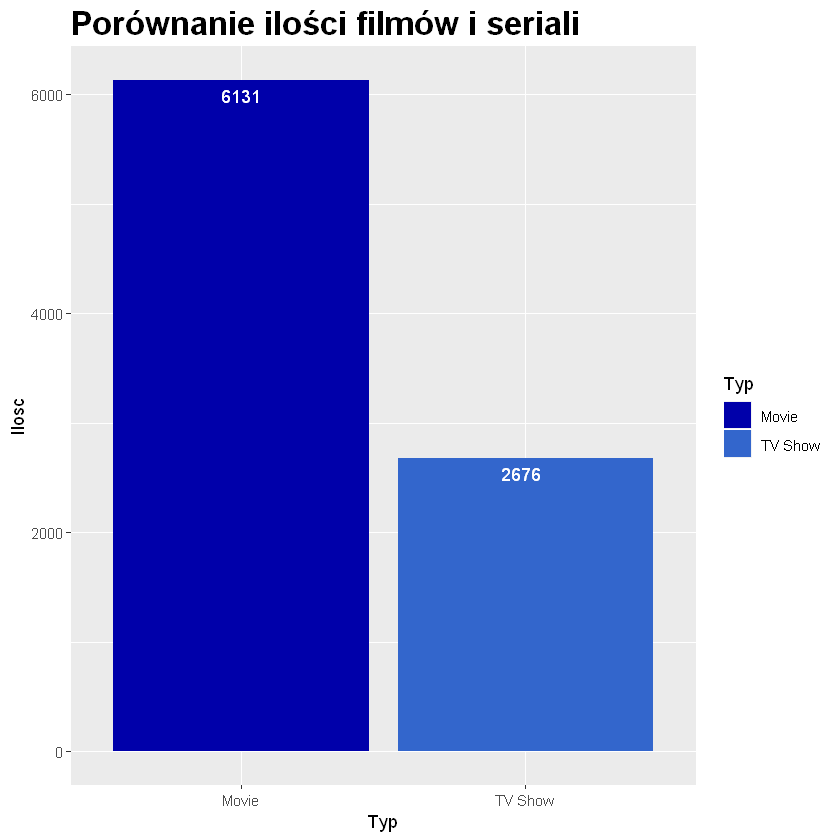

In [13]:
tvShows <- df[df$type == "TV Show", ]
movies <- df[df$type == "Movie", ]
types <- data.frame(Typ = c("TV Show", "Movie"), Ilosc = c(nrow(tvShows), nrow(movies)))

ggplot(types, aes(x = Typ, y = Ilosc, fill = Typ)) + 
  geom_col() + 
  ggtitle("Porównanie ilości filmów i seriali") + 
  theme(plot.title = element_text(size=20, face="bold"),) +
  scale_fill_manual(values = c("#0000AA", "#3366CC")) +
  geom_text_repel(aes(label = stat(y), group = factor(Typ)), position = position_nudge_repel(y = -2), color = "white")

zdecydowanie więcej jest filmów - różnica:

In [14]:
types$Ilosc[2] - types$Ilosc[1] 

[1] 3455

## Kategorie wiekowe  
Następna kolumna: rating  
Przy rozpoznaniu oznaczeń pomogła strona https://help.netflix.com/pl/node/2064/us

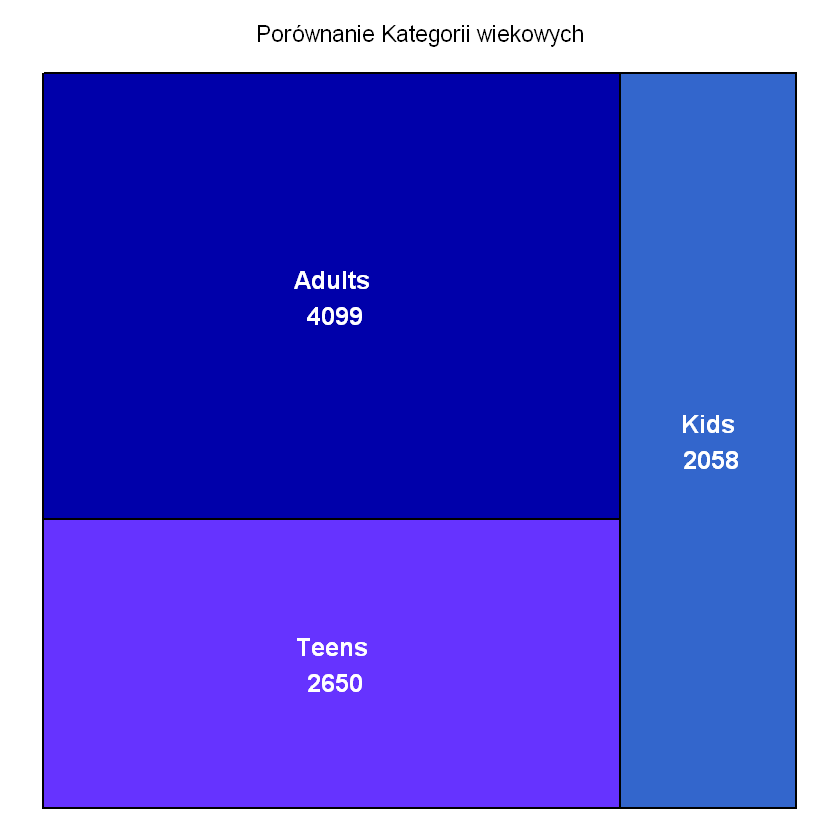

In [15]:
# Dodajemy nową kolumnę z prostszym podziałem: dzieci, nastolatki, dorośli
rating = c('TV-Y', 'TV-Y7', 'TV-G', 'PG', 'TV-PG',
           'PG-13', 'TV-14',
           'R', 'TV-MA', 'NC-17', 'NR', 'UR',
           'TV-Y7-FV', 'G'
           )
age_rating = c('Kids', 'Kids', 'Kids', 'Kids', 'Kids', 
               'Teens', 'Teens', 
               'Adults', 'Adults', 'Adults', 'Adults', 'Adults' 
               ,'Kids', 'Kids'
               )
df$age_rating = as.character(
  factor(
    df$rating,
    levels = rating,
    labels = age_rating
  )
)
treeAge <- count(df, age_rating)
treeAge$labels = paste(treeAge$age_rating,  treeAge$n, sep = "\n ")

treemap(treeAge,
        index = c("labels"), vSize = "n", title = "Porównanie Kategorii wiekowych",
        fontsize.labels=c(15,12), fontcolor.labels=c("white"), palette = c("#0000AA", "#3366CC", "#6633FF"))

Jak widać zdecydowana większość zawartości netflixa jest przeznaczona dla dorosłych  
Jak się to ma do podziału na seriale i filmy?

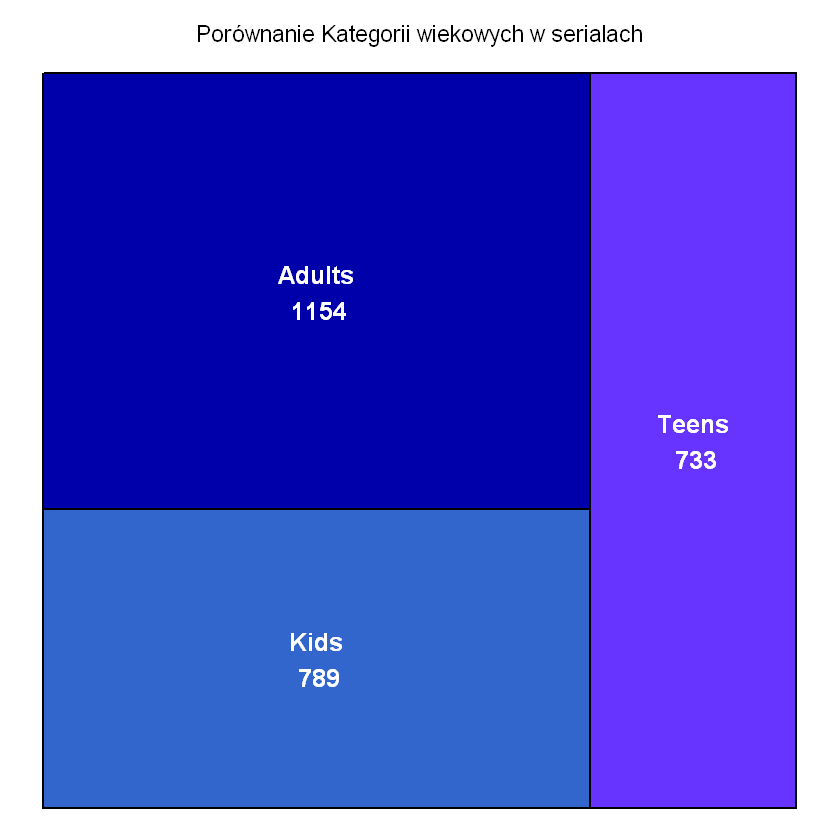

In [16]:
tvShows <- df[df$type == "TV Show", ]
movies <- df[df$type == "Movie", ]

tvShowsRating <- count(tvShows, age_rating)
moviesRating <- count(movies, age_rating)

tvShowsRating$labels = paste(tvShowsRating$age_rating,  tvShowsRating$n, sep = "\n ")
moviesRating$labels = paste(moviesRating$age_rating,  moviesRating$n, sep = "\n ")

treemap(tvShowsRating,
        index = c("labels"), vSize = "n", title = "Porównanie Kategorii wiekowych w serialach",
        fontsize.labels=c(15,12), fontcolor.labels=c("white"), palette = c("#0000AA", "#3366CC", "#6633FF"))

W serialach jest mniej tych dla nastolatków niż dla dzieci

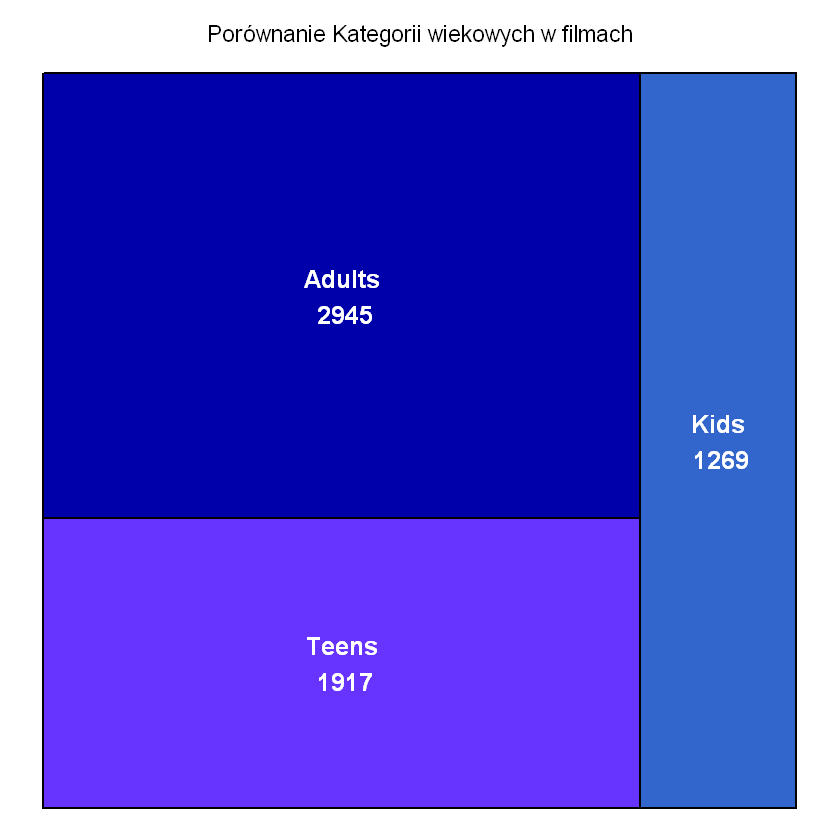

In [17]:
treemap(moviesRating,
        index = c("labels"), vSize = "n", title = "Porównanie Kategorii wiekowych w filmach",
        fontsize.labels=c(15,12), fontcolor.labels=c("white"), palette = c("#0000AA", "#3366CC", "#6633FF"))

Za to w filmach wyraźnie widać różnicę między tymi dla dzieci, a tymi dla nastolatków

## Dodawanie zawartości na przestrzeni lat

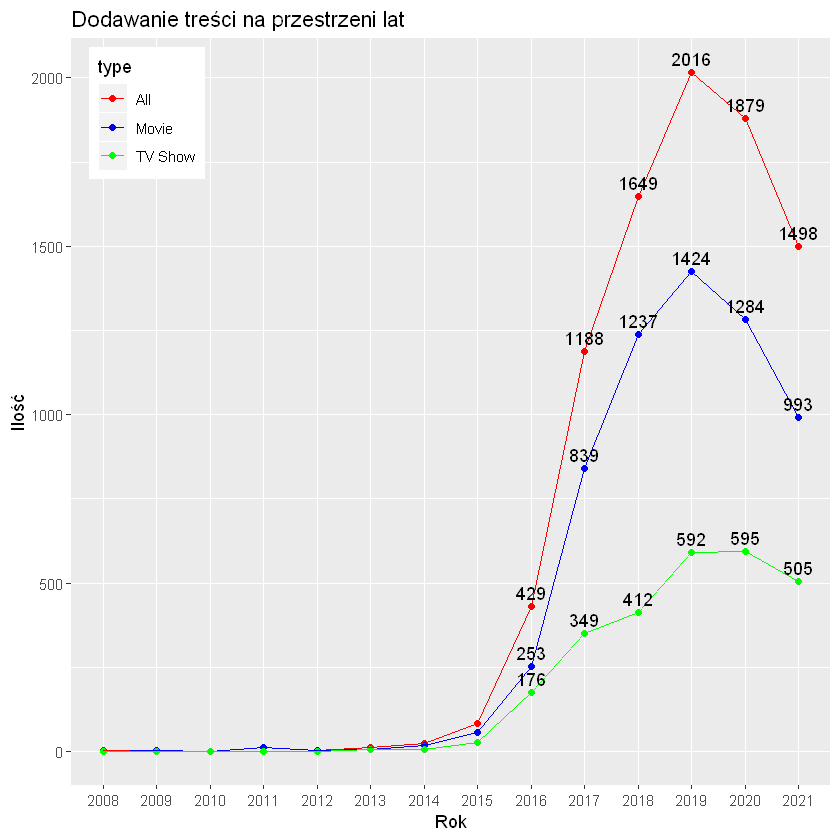

In [89]:
# przygotowanie danych do wykresu z dodawania treści na przestrzeni lat
splitedDate <- data.frame()
splitedDate <- sub('.*, ', '', df$date_added)
plotYear <- data.frame(type = "All", splitedDate)
plotYear <- count(plotYear, splitedDate, type)

plotYear <- slice(plotYear, 1:(n() - 1)) 

splitedDate <- sub('.*, ', '', tvShows$date_added)
plotTvYear <- data.frame(type = "TV Show", splitedDate)
plotTvYear <- count(plotTvYear, splitedDate, type)

plotMissing <- data.frame(type = "TV Show", splitedDate = c("2009", "2010", "2011", "2012"), n = 0)
plotTvYear <- rbind(plotTvYear[1,], plotMissing, plotTvYear[-(1),])

plotTvYear <- slice(plotTvYear, 1:(n() - 1))

splitedDate <- sub('.*, ', '', movies$date_added)
plotMoviesYear <- data.frame(type = "Movie", splitedDate)
plotMoviesYear <- count(plotMoviesYear, splitedDate, type)
plotYearAll <- rbind(plotYear, plotMoviesYear, plotTvYear)

ggplot(plotYearAll, aes(x = splitedDate, y = n, color = type, label = n))  +
  geom_point() + 
  geom_line(data = plotYear, aes(group = 1)) +
  geom_line(data = plotMoviesYear, aes(group = 2)) +
  geom_line(data = plotTvYear, aes(group = 3)) +
  geom_text(data = plotYearAll[plotYearAll$splitedDate == c("", "2016", "2017", "2018", "2019", "2020", "2021"),], 
            color = "black", vjust = -0.5) +
  xlab("Rok")+ylab("Ilość") +
  ggtitle("Dodawanie treści na przestrzeni lat") +
  theme(legend.position = c(0.1,0.9)) +
  scale_color_manual(values = c("red", "blue", "green"))

Zauważalny wzrost zawartości rozpoczął się w 2015 roku  
Wzrost liczby filmów w serwisie Netflix jest znacznie wyższy niż w przypadku programów telewizyjnych  
W latach 2018 - 2020, co roku dodano ponad 1200 nowych filmów  

A w których miesiącach najczęściej były te treści dodawane?


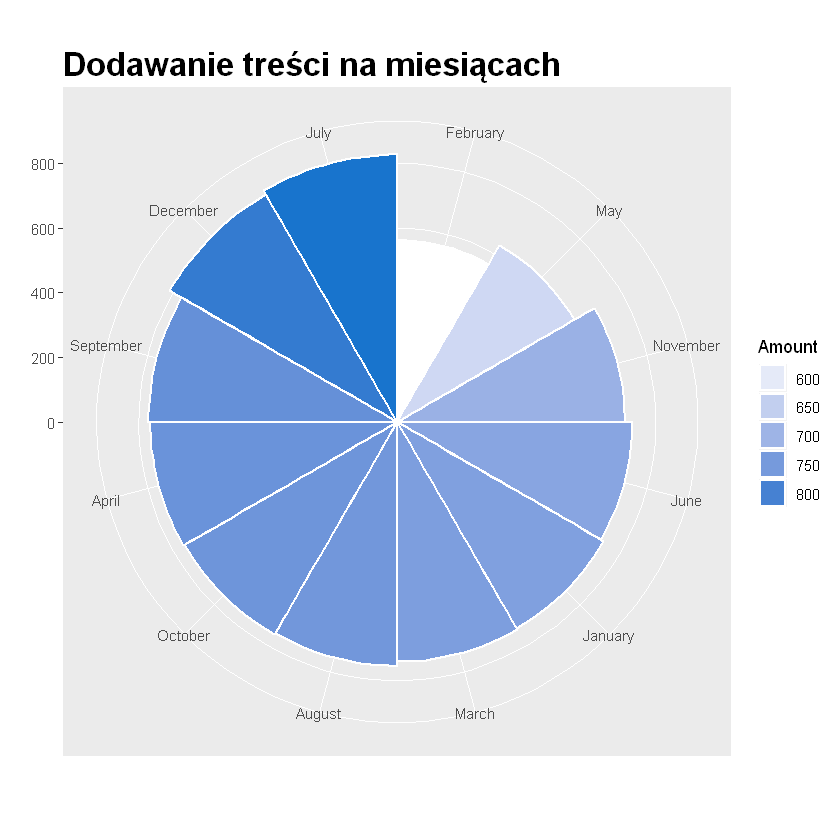

In [19]:
splitedMonth <- sub(' .*', '', df$date_added)
plotMonth <- data.frame(splitedMonth)
plotMonth <- count(plotMonth, splitedMonth)
plotMonth <- slice(plotMonth, which(plotMonth$splitedMonth != "Brak")) 

plotMonth$num = as.character(
  factor(
    plotMonth$splitedMonth,
    levels = month.name,
    labels = c(1:12)
  )
)

plotMonth <- plotMonth[order(as.numeric(plotMonth$num)),]

ggplot(data = plotMonth ,aes(x = reorder(splitedMonth, n), y = n, fill = n)) +
  geom_bar(stat = "identity",width = 1,colour = "white",size = 0.7) +
  coord_polar() +
  scale_fill_gradient(low = "white", high = "dodgerblue3") +
  xlab("") + 
  ylab("") +
  ggtitle("Dodawanie treści na miesiącach") + 
  theme(plot.title = element_text(size=20, face="bold"),) + 
  guides(fill=guide_legend(title="Amount"))

Jak widać najczęściej treść na Netflixie pojawiała się w Grudniu oraz Lipcu

## Gatunki filmowe

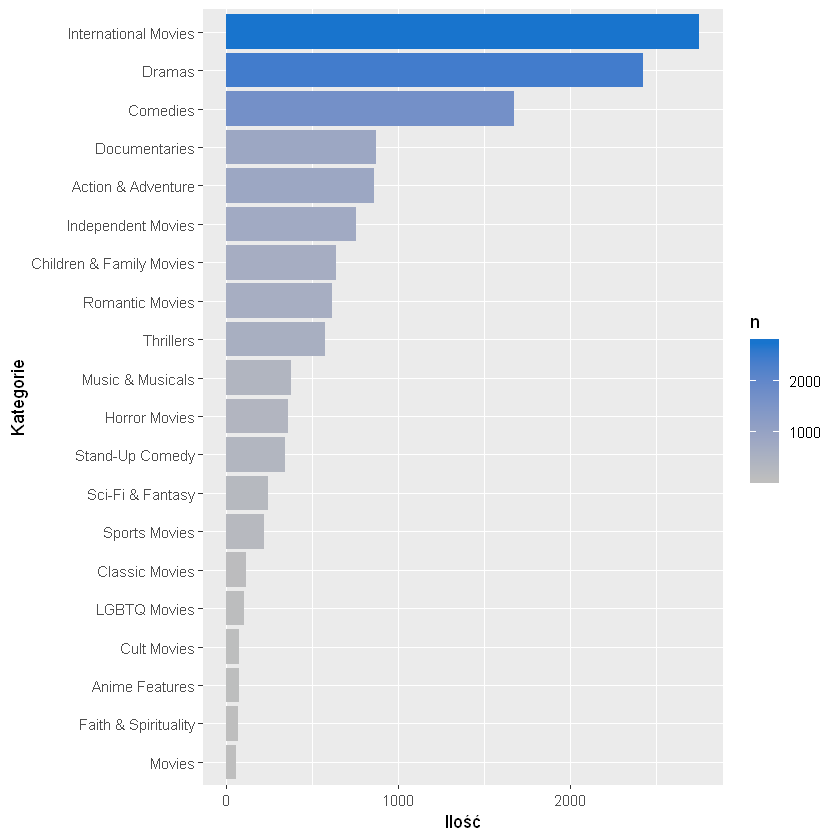

In [29]:
toCategory <- df %>% 
  filter(type=='Movie') %>% 
  separate_rows(listed_in,sep = ', ') %>% 
  group_by(listed_in) %>% 
  count()

ggplot(toCategory, aes(x = reorder(listed_in, n), y = n, fill = n)) +
  geom_bar(stat = 'identity') +
  scale_fill_gradient(low = "grey", high = "dodgerblue3") +
  xlab("Kategorie") + ylab("Ilość") +
  coord_flip()

## Korelacja gatunków

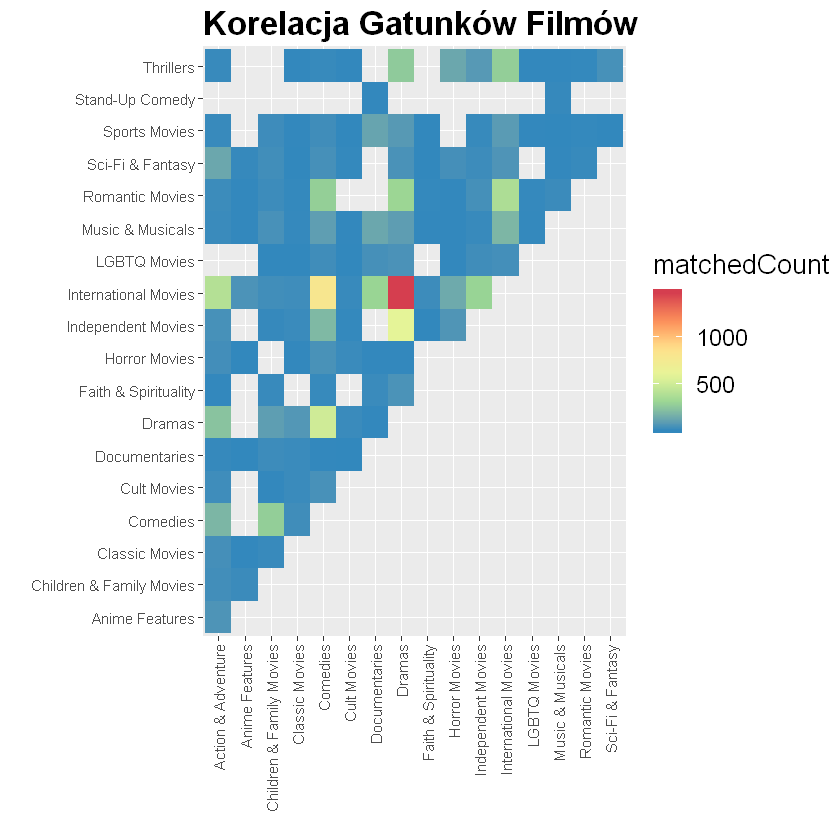

In [21]:
dfCategories <- df %>% 
  select(c('show_id','type','listed_in')) %>% 
  separate_rows(listed_in, sep = ',') %>%
  rename(Category = listed_in)
dfCategories$Category <- trimws(dfCategories$Category)

dfUniqueCategories <- dfCategories %>% group_by(type,Category) %>%  summarise()

# Korelacja gatunków w filmach
Category1 = subset(dfUniqueCategories, type == 'Movie')$Category
Category2 = subset(dfUniqueCategories, type == 'Movie')$Category
dfCategoryCorrelationsMovies <- data.frame(expand.grid(type = 'Movie', Category1, Category2))

# Korelacja gatunków w serialach
Category1 = subset(dfUniqueCategories, type == 'TV Show')$Category
Category2 = subset(dfUniqueCategories, type == 'TV Show')$Category
dfCategoryCorrelationsTv <- data.frame(expand.grid(type = 'TV Show', Category1, Category2))

# Połączenie obu data.frame'ów
dfCategoryCorrelations <- rbind(dfCategoryCorrelationsMovies, dfCategoryCorrelationsTv)
# Zliczamy wszystkie połączenia gatunków
dfCategoryCorrelations$matchedCount <- apply(dfCategoryCorrelations, MARGIN = 1,FUN = function(x) {
  length(intersect(subset(dfCategories, type == x['type'] & Category == x['Var2'])$show_id,
                   subset(dfCategories, type == x['type'] & Category == x['Var3'])$show_id))})

# Usuwamy korelacje gatunku samego ze sobą oraz wszystkich tych których była zerowa
dfCategoryCorrelations <- subset(dfCategoryCorrelations, (as.character(Var2) < as.character(Var3)) &  matchedCount > 0)

ggplot(subset(dfCategoryCorrelations, type == 'Movie'), aes(x = Var2, y = Var3, fill = matchedCount)) + 
  geom_tile() + 
  ggtitle("Korelacja Gatunków Filmów") + 
  theme(plot.title = element_text(size=20, face="bold"),) +
  scale_fill_distiller(palette = "Spectral") + 
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
  theme(legend.text = element_text(size = 14), legend.title = element_text(size = 16)) +
  xlab("") + ylab("")

Najwięcej filmów posiada gatunki "International Dramas"  
Dodatkowo można zauważyć, że "Wiara i duchowość" nie pokrywają się z filmami "LGBTQ".

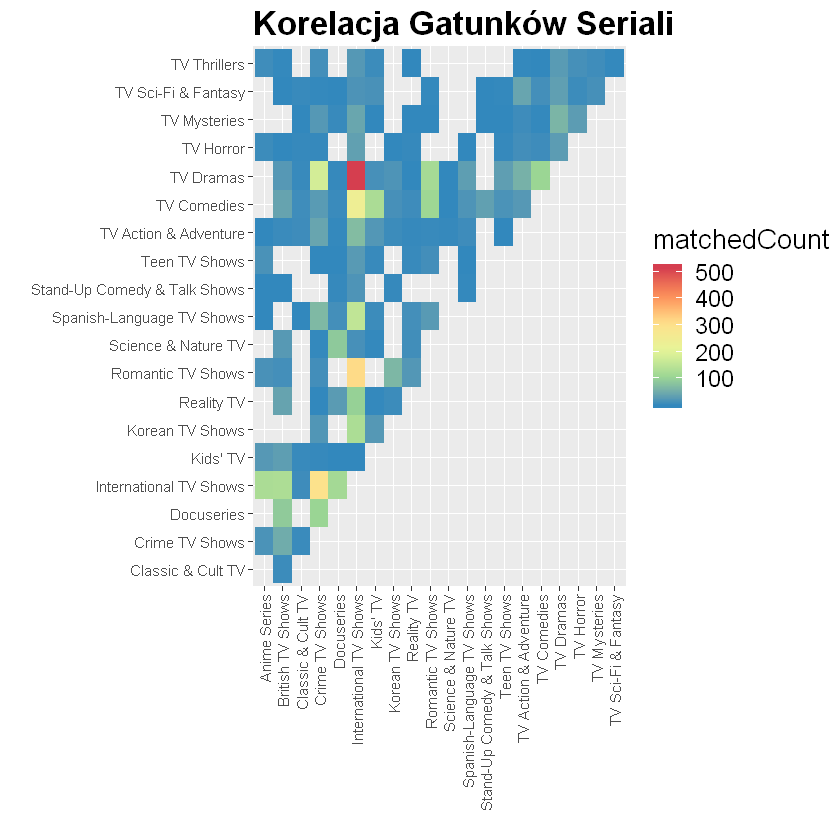

In [22]:
ggplot(subset(dfCategoryCorrelations, type == 'TV Show'), aes(x = Var2, y = Var3, fill = matchedCount)) + 
  geom_tile() + 
  ggtitle("Korelacja Gatunków Seriali") + 
  theme(plot.title = element_text(size=20, face="bold"),) +
  scale_fill_distiller(palette = "Spectral") + 
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
  theme(legend.text = element_text(size = 14), legend.title = element_text(size = 16)) +
  xlab("") + ylab("")

Tutaj tak samo najwięcej połączeń gatunków w serialach to "International Dramas"

## Podział względem krajów  

Wyznaczmy top 15 dla krajów

In [23]:
topCountries <- df %>%  
  separate_rows(country,sep="(, |,)") %>%
  group_by(country) %>%  
  summarise(count=n()) %>% 
  arrange(desc(count))
head(topCountries)

country,count
United States,3690
India,1046
Brak danych,831
United Kingdom,806
Canada,445
France,393


Widzimy że jest sporo braków, ale mimo wszystko spróbujemy bez tych danych

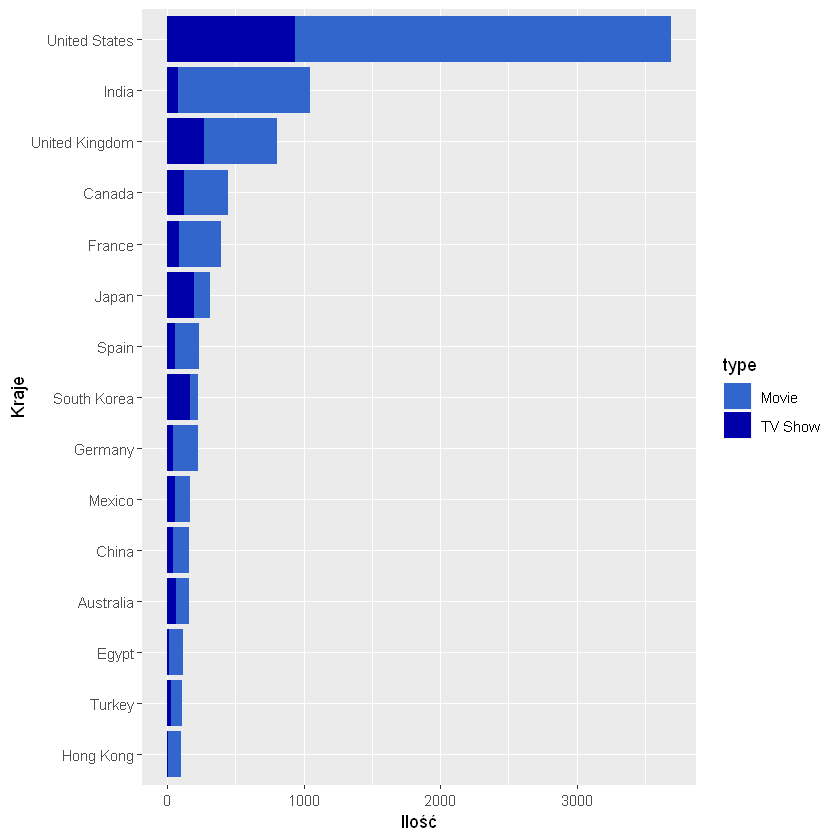

In [24]:
topCountries <- slice(topCountries, which(topCountries$country != "Brak danych"))

topCountriesNames <- as.vector(topCountries$country[1:15])

toPlot <- df %>%  
  separate_rows(country, sep = ", ") %>%
  filter(country %in% topCountriesNames) %>% 
  mutate(country=factor(country, levels = topCountriesNames)) %>% 
  group_by(country, type) %>% 
  summarise(count = n()) 

ggplot(toPlot, aes(x = reorder(country, count), y = count, fill = type)) +
  scale_fill_manual(values = c("#3366CC", "#0000AA")) + 
  geom_bar(stat = 'identity') +
  ylab("Ilość") + xlab("Kraje") +
  coord_flip()

Jak widać Stany zjednoczone górują ilością.  
W większości przypadków widać przewagę Filmów nad serialami  
Jednak widać, że nie w każdym przypadku tak jest.  


Które kraje mają więcej seriali niż filmów na tej platformie?  

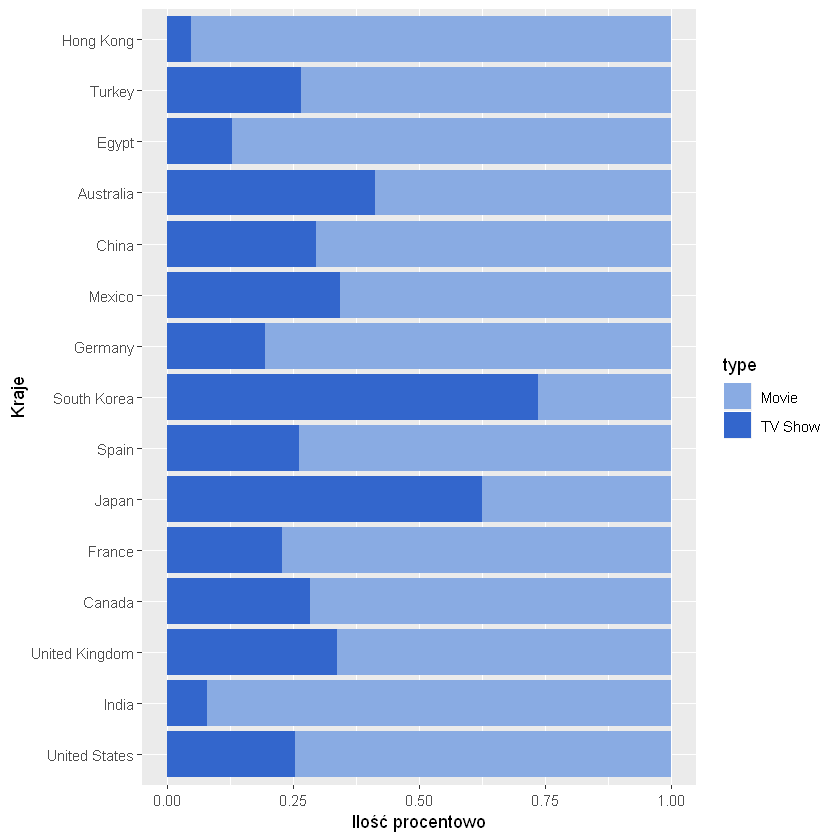

In [25]:
ggplot(toPlot, aes(x = country, y = count, fill = type)) +
  geom_bar(stat = 'identity', position = 'fill') +
  scale_fill_manual(values = c("#89ABE3", "#3366CC")) + 
  ylab("Ilość procentowo") + xlab("Kraje") +
  coord_flip()

Jak widać na wykresie,  
krajami które mają na netflixie więcej seriali niż filmów są Japonia oraz Korea Południowa.  
Natomiast Hong Kong prawie w ogóle nie ma seriali

In [26]:
toPlot[toPlot$country == "Hong Kong",]

country,type,count
Hong Kong,Movie,100
Hong Kong,TV Show,5


Ma ich tylko 5.